In [1]:
pwd

'/home/mohit19014/Hostility Detection/Final Experiments/HindiBERT/Final Test Pipeline'

In [2]:
cd /home/mohit19014/Hostility Detection/

/home/mohit19014/Hostility Detection


In [3]:
ls

 ASL/                 'Raw Text with EMoji Attn Loss.pdf'
 Code/                'Raw Text with EMoji Attn Loss.png'
 Data/                'Raw Text with EMoji Total Loss.pdf'
 Dumps/               'Raw Text with EMoji Total Loss.png'
'Final Experiments'/   sample.tex
 Models/               Tensorboard/
 Photos/


In [4]:
!nvidia-smi

Sun Apr 11 17:15:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   40C    P0    42W / 250W |   6910MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Installing Required Libraries

In [5]:
# pip install torchsummary -q

In [6]:
# pip install fasttext

In [7]:
# pip install gensim

In [8]:
# pip install transformers -q

In [9]:
# pip install sentencepiece -q

####Importing Libraries

In [10]:
### General
import re
import copy
import string
import pickle
import numpy as np
import pandas as pd
import fasttext
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

### Sklearn
import joblib
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

### Transformers
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup


### ASL
from ASL.src.loss_functions.losses import AsymmetricLoss

#### Configuration Class


In [11]:
class Config1:
    def __init__(self):
        super(Config1, self).__init__()

        self.SEED       = 42
        self.MODEL_PATH = 'Data/Pretrained/HindiBERT/Checkpoint 2500/'



        # data
        self.PERCENTAGE_DATA  = 10
        self.TOKENIZER        = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH       = 128
        self.BATCH_SIZE       = 16
        self.VALIDATION_SPLIT = 0.10
        self.PREPROCESS_INPUT = False

        # Coarse-grained or Fine-Grained
        self.NUM_LABELS           = 4                                        ### 1:CG   2:Combine    4:FG
        self.COARSE_GRAINED       = True if self.NUM_LABELS ==1 else False 
        self.COARSE_GRAINED_CLASS = 'Hostile'                                ### 'Fake' 'Defamation' 'Hate' or 'Offensive' 
        
        # Combining Hostile Dimensions
        self.COMBINE_HATE_OFFENSIVE  = False     #True if self.NUM_LABELS ==2 else False
        self.COMBINE_DEFAMATION_FAKE = False     #if self.NUM_LABELS ==2 else False


        ###Features to include
        self.SUPERVISED_LEXICON_ATTENTION = True
        self.HOSTILITY_LEXICON            = True
        self.LEXICON_AVERAGE              = False
        self.EMOJI_INFO                   = True
        self.EMBED_EMOJI                  = False    ### Doesnot do preprocessing, just adds emoji text into the post
        self.HASHTAG_INFO                 = True
        self.EMOJI_FLAG                   = " with Emoji"       ### "" or " without Emoji" or " with Emoji" --> space at beginning
        self.TOKENIZER_FLAG               = "Sentence Piece"
        self.PREPROCESSING_FLAG           = "Raw Text"
        
        ### Lexicon Parameters
        self.PAD_LENGTH = 128   ### Makes Sequence Length, Lexicon Vector, and gold attention vector 
        

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.NUMBER_OF_BERT_LAYERS = 1
        self.FULL_FINETUNING = True
        self.LR = 0.001
        self.OPTIMIZER = 'AdamW'
        self.OUTPUT_HIDDEN_STATE=True
        self.OUTPUT_ATTENTIONS = True
        self.EPOCHS = 50

        
        ### Loss Hyperparameters
        self.DEFAMATION_LOSS_LAMBDA = 1.0
        self.FAKE_LOSS_LAMBDA       = 1.0
        self.HATE_LOSS_LAMBDA       = 1.0
        self.OFFENSIVE_LOSS_LAMBDA  = 1.0

        
        ### Load Checkpoint
        self.SAVE_BEST_ONLY   = True
        self.LOAD_CHECKPOINT  = False
        self.FINE_TUNE_COARSE = False
        self.CHECKPOINT_PATH  = ""
        self.MODEL_FOLDER     = "Final Experiments/HindiBERT/4LSTM + 4MHA/BCE + MSE/"

        ### Visualization
        self.VISUALIZE_EMBEDDINGS = False
        self.PLOT_LOSS = True

        ### Evaluation 
        self.THRESHOLD = 0.5
        self.SERVER    = True

config = Config1()

warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=ResourceWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)

<h3>Helper Functions

In [12]:
def get_texts(df):
    return df['Raw Text' + config.EMOJI_FLAG]

In [13]:
def get_processed_texts(df):
    return df['Preprocessed'+ config.EMOJI_FLAG]

In [14]:
def get_tokenized_texts(df):
    return df['Sentence Piece Raw Text' + config.EMOJI_FLAG]

In [15]:
def get_labels(df):
    if(config.COARSE_GRAINED):
        return [[float(i)] for i in df[config.COARSE_GRAINED_CLASS]]  
    
    else:
        labels = []
        for i in range(len(df)):
            label = []
            label.append(df['Defamation'][i])
            label.append(df['Fake'][i])
            label.append(df['Hate'][i])
            label.append(df['Offensive'][i])
            label = [float(i) for i in label]
            labels.append(label)
        return labels

In [16]:
def get_gold_attention_vectors(df):
    gold_attn_vectors = []
    for i in range(len(df)):
        gold_attn_vector = []
        gold_attn_vector.append(np.asarray(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' DGA'][i][:config.PAD_LENGTH]))
        gold_attn_vector.append(np.asarray(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' FGA'][i][:config.PAD_LENGTH]))
        gold_attn_vector.append(np.asarray(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' HGA'][i][:config.PAD_LENGTH]))
        gold_attn_vector.append(np.asarray(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' OGA'][i][:config.PAD_LENGTH]))
        gold_attn_vectors.append(gold_attn_vector)
    return gold_attn_vectors

In [17]:
def get_emoji_vectors(df):
    return df['Avg Emoji Vectors'].values

In [18]:
def get_hashtag_vectors(df):
    return df['Avg Hashtag Vectors']

In [19]:
def get_lexicons(df):
    if(config.LEXICON_AVERAGE):
        softmax_lex_avg = []
        for i in range(len(df)):
            softmax_lex_avg.append(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' Lex Avg'][i][:config.PAD_LENGTH,:]) ### returns [len(df), 128, 4] sized array
        return softmax_lex_avg
    else:
        softmax_lex_padded = []
        for i in range(len(df)):
            softmax_lex_padded.append(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' Lex Pad'][i][:config.PAD_LENGTH,:]) ### returns [len(df), 128, 4] sized array
        return softmax_lex_padded

In [20]:
def get_lexicon_masks(df):
    lex_mask = []
    for i in range(len(df)):
        lex_mask.append(df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' Mask'][i][:config.PAD_LENGTH]) ### returns [len(df), 128, 4] sized array
    return lex_mask

In [21]:
def get_mha_masks(df):
    mha_masks = []
    for i in range(len(df)):
        mha_mask = df[config.PREPROCESSING_FLAG + config.EMOJI_FLAG + ' Mask'][i][:config.PAD_LENGTH] ### returns [len(df), 128, 4] sized array
        mha_mask = 1 - mha_mask
        mha_mask = mha_mask.astype(int)
        mha_masks.append(mha_mask)
    return mha_masks

In [22]:
# def get_indicft_embeddings(df):
#     indicft_vectors = []
#     for i in range(len(df)):
#         indicft_vectors.append(df['Padded IndicFT Embeddings Preprocessed '+ config.EMOJI_FLAG][i][:config.PAD_LENGTH, :])
#     return indicft_vectors

In [23]:
### Preprocessing Flag = 0 --> Raw Text 
###               Flag = 1 --> Without Emojis
###               Flag = 2 --> With Emoji

def prepocess(df,flag):
    
    for i in range(len(df)):
        text = df['Post'][i]
        
        if(flag==1):
            ## Removing Emojis
            emojis = re.compile("["      u"\U0001F600-\U0001F64F"  # emoticons
                                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                        u"\U00002500-\U00002BEF"  # chinese char
                                        u"\U00002702-\U000027B0"
                                        u"\U00002702-\U000027B0"
                                        u"\U000024C2-\U0001F251"
                                        u"\U0001f926-\U0001f937"
                                        u"\U00010000-\U0010ffff"
                                        u"\u2640-\u2642"
                                        u"\u2600-\u2B55"
                                        u"\u200d"
                                        u"\u23cf"
                                        u"\u23e9"
                                        u"\u231a"
                                        u"\ufe0f"  # dingbats
                                        u"\u3030"
                                        "]+", flags=re.UNICODE)
            text =  emojis.sub(r'', text)
            
        if(flag==2):
            text = emoji.demojize(text, delimiters=("" , " "))
            
        df.at[i,column_names[flag]] = text
        
    return df

In [24]:
def plot_tsne(embeddings,labels):

    tsne = TSNE(n_components=2, random_state=0)

    outer_cname = { '0' : {1: 'Defamation', 0:'Non-Defamation'},
                    '1' : {1: 'Fake', 0:'Non-Fake'},
                    '2' : {1: 'Hate', 0:'Non-Hate'},
                    '3' : {1: 'Offensive', 0:'Non-Offensive'},
                    '4' : {1: 'Hostile', 0:'Non-Hostile'}}

    class_mapping = {'Defamation': '0',
                     'Fake': '0',
                     'Hate': '2',
                     'Offensive': '3',
                     'Hostile': '4'}

    if(config.COARSE_GRAINED):
        transformed = tsne.fit_transform(embeddings)
        fig, ax = plt.subplots()
        for label in np.unique(labels): 
            indices = [i for i, l in enumerate(labels) if l == label]
            x = np.take(transformed[:,0], indices)
            y = np.take(transformed[:,1], indices)

            cdict = {1: 'red', 0: 'blue'}
            cname = outer_cname[class_mapping[config.COARSE_GRAINED_CLASS]]
            ax.scatter(x,y, color = cdict[label], label=cname[label])
        
        ax.legend(loc='best')
        plt.show()

    else:
        transformed = tsne.fit_transform(embeddings)
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

        
        counter = 0
        all_labels = labels      
        for row in ax:
            for col in row:
                labels  = all_labels[:,counter]
                for label in np.unique(labels): 
                    indices = [i for i, l in enumerate(labels) if l == label]
                    x = np.take(transformed[:,0], indices)
                    y = np.take(transformed[:,1], indices)

                    cdict = {1: 'red', 0: 'blue'}
                    cname = outer_cname[str(counter)]
                    col.scatter(x,y, color = cdict[label], label=cname[label], alpha =0.5)
                    col.legend(loc='best')
                counter += 1
        plt.show()

<h3>Dataset Class


In [25]:
class HindiHostilityDataset(Dataset):
    def __init__(self, dataset_path):
        super(HindiHostilityDataset, self).__init__()

        df          = pickle.load(open(dataset_path, 'rb'))
        
        if(config.COARSE_GRAINED == False and config.SERVER == True):
            df = df[df['Hostile']==1]
            df = df.reset_index(drop=True)       
        
        num_samples = int(config.PERCENTAGE_DATA*len(df)/100)
        df          = df.iloc[:num_samples,:] 
        
        print("Taking ",num_samples," only")
        if(config.PREPROCESS_INPUT):
            df = preprocess(df)

           
        self.texts             = get_texts(df)
        self.processed_texts   = get_processed_texts(df)
        self.tokenized_texts   = get_tokenized_texts(df)
        self.labels            = get_labels(df)
        self.gold_attn_vectors = get_gold_attention_vectors(df) ### Value at an index is a list four 50 dim vectors
        self.lexicon_vectors   = get_lexicons(df)               ### A vector of 50*4 size or 4 size vector
        self.lexicon_masks     = get_lexicon_masks(df)          ### A vector of size 128
        self.mha_masks         = get_mha_masks(df)
        self.emoji_vectors     = get_emoji_vectors(df)          ### A 300 dimension mean vector
        self.hashtag_vectors   = get_hashtag_vectors(df)        ### A 300 dimension mean vector

        self.max_length        = config.MAX_LENGTH
        self.tokenizer         = config.TOKENIZER
        

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):

        tokenized_conts = self.tokenizer.encode_plus( self.texts[index], 
                                                      max_length=self.max_length,
                                                      padding='max_length',
                                                      truncation=True,
                                                      return_attention_mask=True,
                                                      return_token_type_ids=False,
                                                      return_tensors='pt')
        
        post_input_ids       = tokenized_conts['input_ids'].squeeze()
        post_attention_masks = tokenized_conts['attention_mask'].squeeze()

#         print(type(post_attention_masks))
#         print(type(post_attention_masks[0]))

        return { 'posts': {
                          'text': self.texts[index],
                          'processed_text'   : self.processed_texts[index],
                          'tokenized_text'   : self.tokenized_texts[index],
                          'lexicon_vector'   : torch.Tensor(self.lexicon_vectors[index]),
                          'gold_attn_vectors': torch.Tensor(self.gold_attn_vectors[index]),
                          'lexicon_mask'     : torch.Tensor(self.lexicon_masks[index]).type(torch.ByteTensor),
                          'mha_mask'         : torch.Tensor(self.mha_masks[index]).type(torch.ByteTensor),
                          'emoji_vector'     : torch.Tensor(self.emoji_vectors[index]),
                          'hashtag_vector'   : torch.Tensor(self.hashtag_vectors[index]),
                          'input_ids'        : post_input_ids,
                          'attention_masks'  : post_attention_masks
                        },
                
                 'labels': torch.Tensor(self.labels[index])#.float()
                }


#### SLATE

Parameters:


*   Droput = 0.25
*   Pad Length = 128
*   Lexicon LSTM Hidden Size = 64, bidirectional true so = 128
*   Second last layer size = 128
*   Last layer = 4 nodes



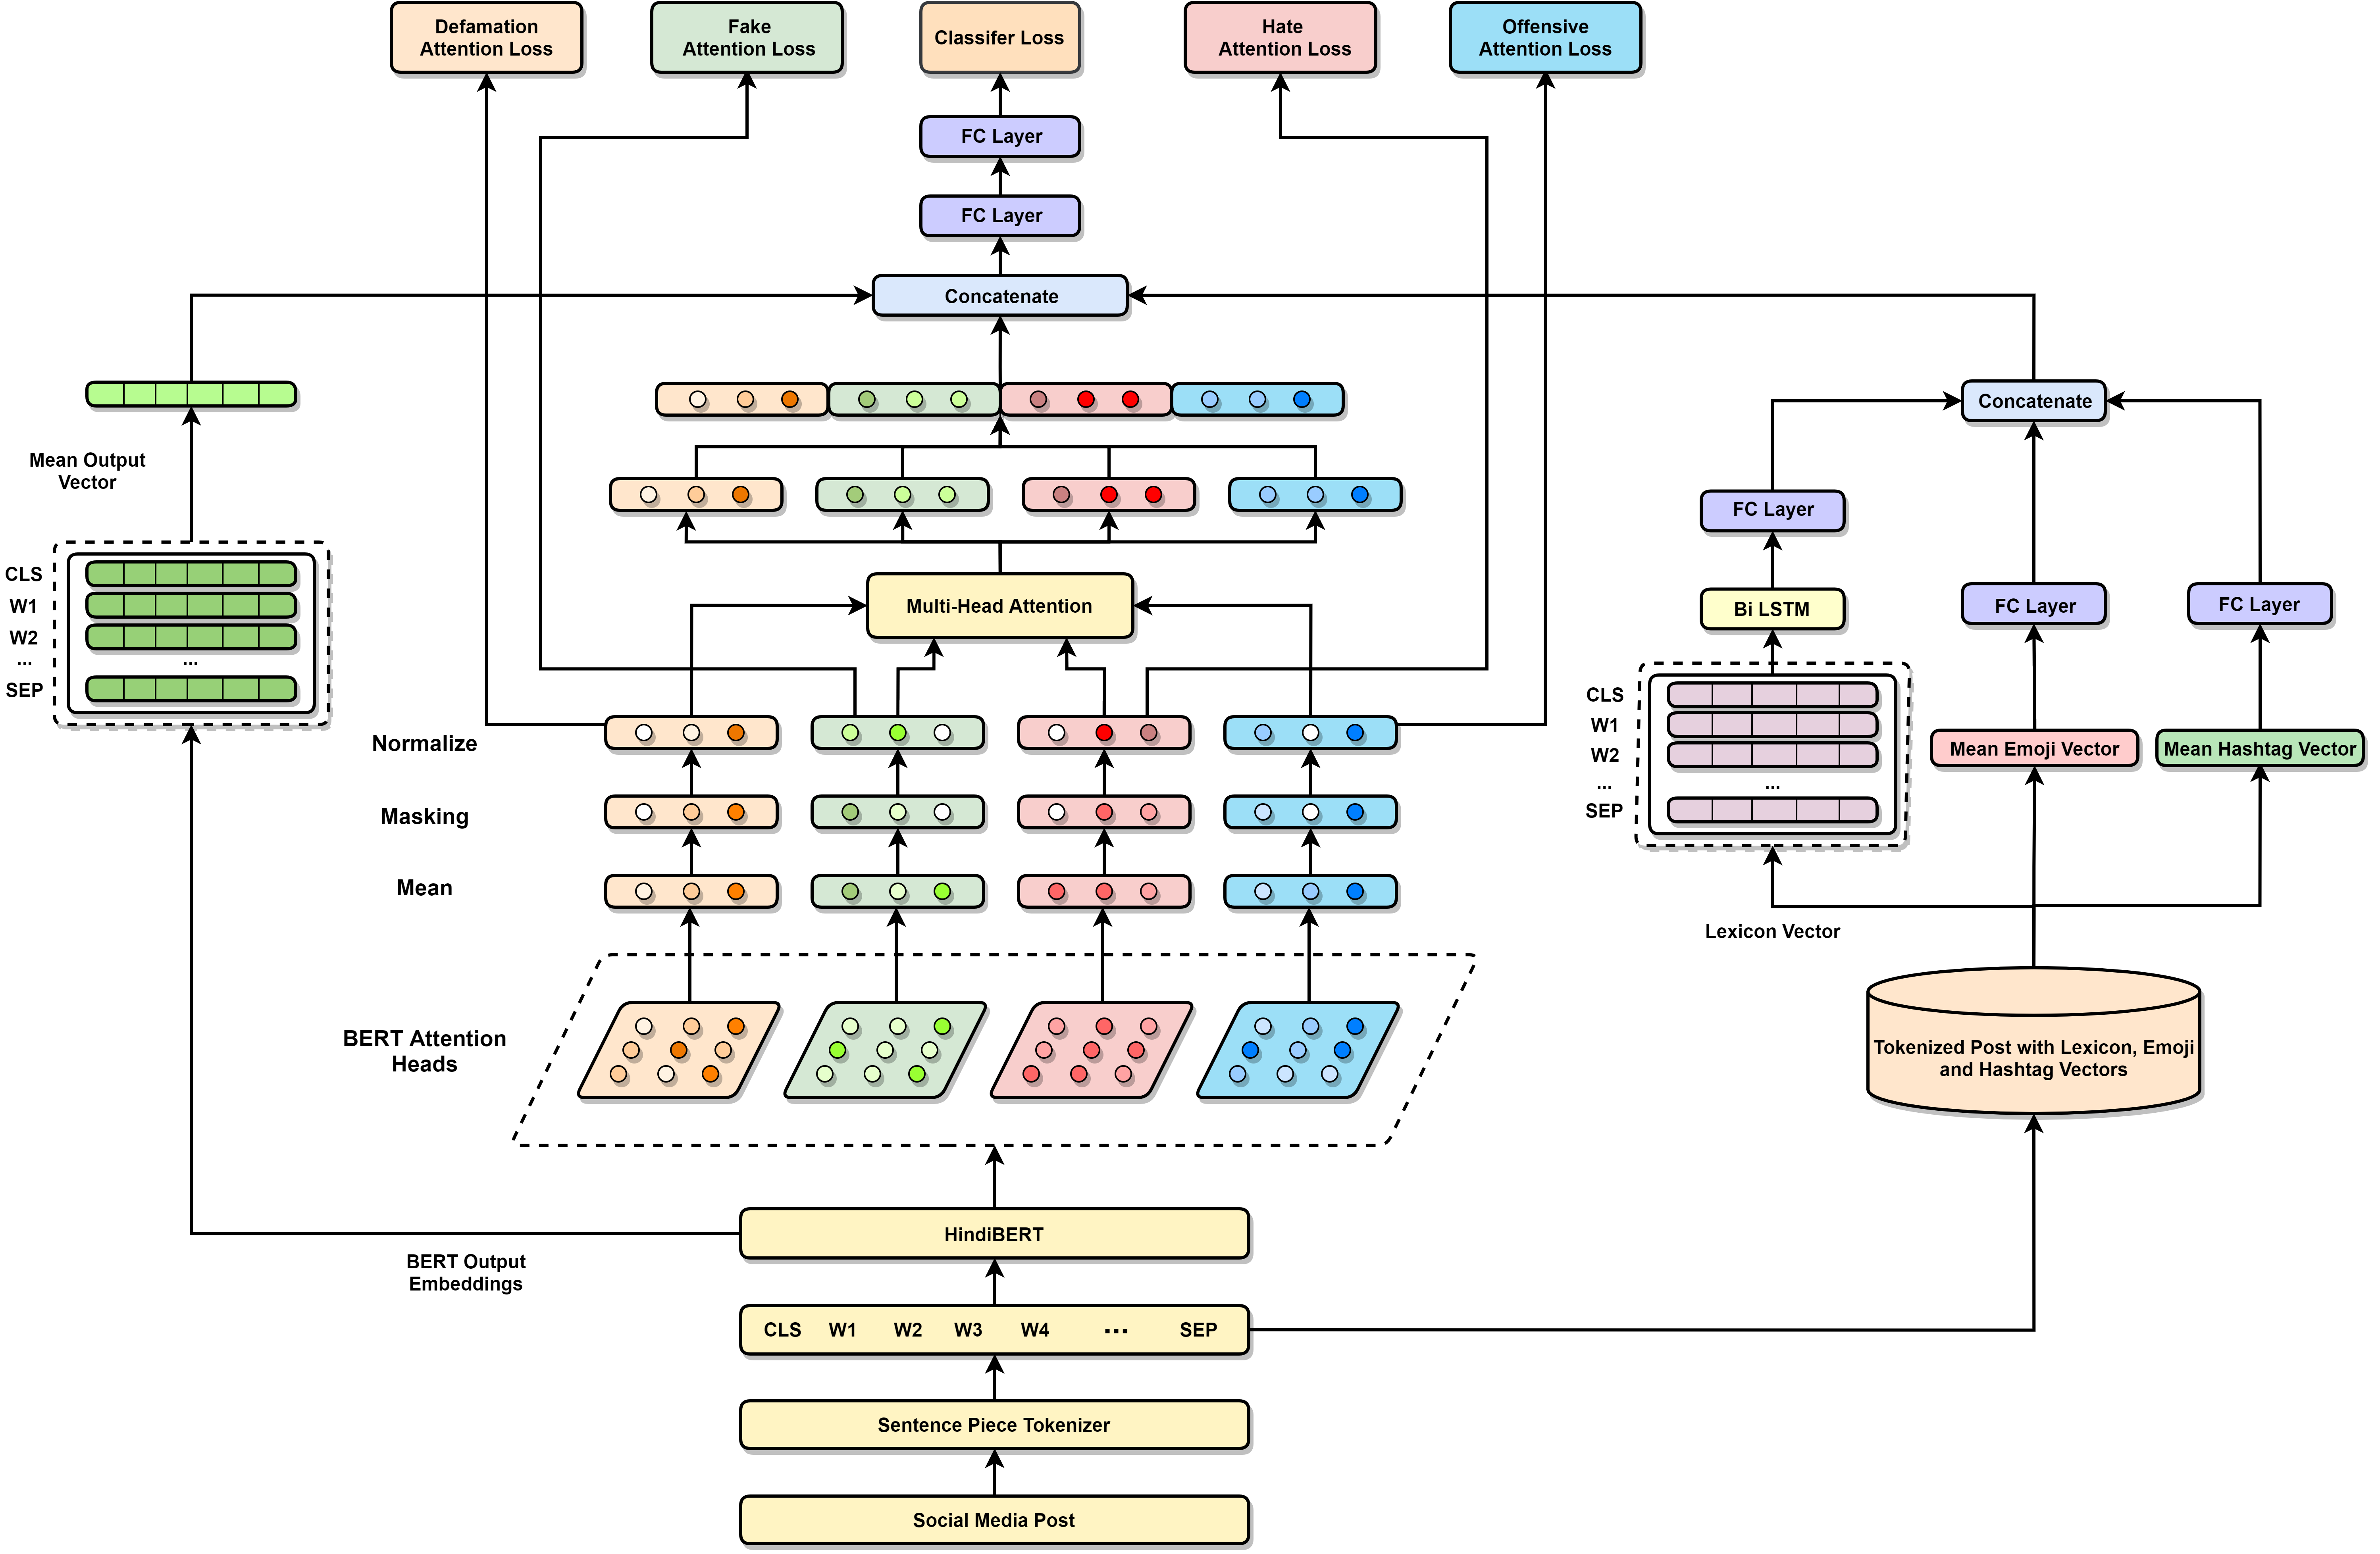

In [26]:
    from PIL import Image
    img = Image.open("Photos/SLATE.png")
    img

In [27]:
def weighted_avg(a, b):
    b = torch.unsqueeze(b,2)
    a = a.permute(0,2,1)
    c = torch.bmm(a,b)
    c = c.squeeze(2)
    return c

In [28]:
def attention_mask(vec, mask, dim=1, epsilon=1e-5):
    masked = vec * mask
    masked_sums = masked.sum(dim, keepdim=True) + epsilon
    return (masked/masked_sums)

In [51]:
class BaseModel2(nn.Module):
    def __init__(self):
        super(BaseModel2, self).__init__()
    
        ### Main stem ==> IndicBERT + LSTM +Attn (128) + Lexicon(LSTM) (32) + Emoji (300--> 32) ==> 192
        ### Predicted Gold Attentions: 50 each ==> 200
        ### Concat ==> 392 --> 128 --> 4
    
        self.bert_model          = AutoModel.from_pretrained(config.MODEL_PATH, output_hidden_states = config.OUTPUT_HIDDEN_STATE, output_attentions = config.OUTPUT_ATTENTIONS)
        self.dropout             = nn.Dropout(0.25)
              
#         self.complete_mha = nn.MultiheadAttention(embed_dim = 50, num_heads=5)
        self.complete_mha = nn.MultiheadAttention(embed_dim = 128, num_heads=4)


        self.lstm_lexicon                  = nn.LSTM(input_size = 4, hidden_size = 32, batch_first=True, bidirectional=True )

        ## Gave poor results with Lex Encoder
        ##self.lex_encoder_layer     = nn.TransformerEncoderLayer(d_model=4, nhead=4, dropout=0.25)
        ##self.lex_encoder           = nn.TransformerEncoder(self.lex_encoder_layer, num_layers=6) ### Seq, Batch, Embedding

        self.linear_lexicon                = nn.Linear(64, 32)
        self.linear_emoji                  = nn.Linear(300, 32)
        self.linear_hashtag                = nn.Linear(300, 32)

        
        self.concat_fc1                    = nn.Linear(864, 128)
        self.concat_fc2                    = nn.Linear(128, config.NUM_LABELS)



    def forward(self, input_ids, attention_masks, gold_attn_vectors=None, lexicon_vector=None,lexicon_masks =None, mha_masks=None, emoji_vector=None, hashtag_vector=None):
        
        output_embeddings, hidden_states, attention = self.bert_model(input_ids = input_ids, attention_mask = attention_masks).values()

        bert_attn = attention[-1]                      ### [16,4,128,128]
        
        d_bert_attn = bert_attn[:,0,:config.PAD_LENGTH,:config.PAD_LENGTH]
        f_bert_attn = bert_attn[:,1,:config.PAD_LENGTH,:config.PAD_LENGTH]
        h_bert_attn = bert_attn[:,2,:config.PAD_LENGTH,:config.PAD_LENGTH]
        o_bert_attn = bert_attn[:,3,:config.PAD_LENGTH,:config.PAD_LENGTH]

        d_bert_attn = torch.mean(d_bert_attn, 1)      ### [16,50]
        f_bert_attn = torch.mean(f_bert_attn, 1)      ### [16,50]
        h_bert_attn = torch.mean(h_bert_attn, 1)      ### [16,50]
        o_bert_attn = torch.mean(o_bert_attn, 1)      ### [16,50]
        
        d_bert_attn = attention_mask(d_bert_attn, lexicon_masks)
        f_bert_attn = attention_mask(f_bert_attn, lexicon_masks)
        h_bert_attn = attention_mask(h_bert_attn, lexicon_masks)
        o_bert_attn = attention_mask(o_bert_attn, lexicon_masks)


        ### original Input     --> N S E --> 16 128 768
        ### Transformer Input  --> S N E --> 128 16 768
        ### Transformer Output --> S N E --> 128 16 768
        
        
        concat_attn       = torch.cat((d_bert_attn, f_bert_attn, h_bert_attn, o_bert_attn),0)
        concat_attn       = concat_attn.reshape(4, len(input_ids), config.PAD_LENGTH)
        concat_attn       = self.complete_mha(concat_attn, concat_attn, concat_attn)
        concat_attn       = concat_attn[0].permute(1,0,2)
        concat_attn       = torch.flatten(concat_attn, start_dim=1)                ### [16,512]
        
#         print(concat_attn.shape)
        
        ### Main Stem --> Augmenting Lexicon Vector + Emoji Vector

        output_embeddings = torch.mean(output_embeddings, 1)
#         output_embeddings = output_embeddings[:,0,:] ### CLS EMbedding
#         print(output_embeddings.shape)
        
        lexicon_vector = lexicon_vector[:, :, :-1]
        lexicon_all_hidden_states, (lexicon_last_hidden_state, lexicon_cell_state) = self.lstm_lexicon(lexicon_vector) # [16, 50, 64]
        lexicon_sum_hidden_states = torch.sum(lexicon_all_hidden_states, 1)  ### [16,64]
        lexicon_drop = self.dropout(lexicon_sum_hidden_states)               ### [16,64]
        lexicon_linear = self.linear_lexicon(lexicon_drop)                   ### [16,32]
   
    
#         lex_op = self.lex_encoder(lexicon_vector.permute(1,0,2))
#         lex_op = lex_op.permute(1,0,2)
#         lex_op = torch.flatten(lex_op, 1)
#         lex_op = self.dropout(lex_op)

        
#         print(lex_op.shape)
        
        emoji_vector      = self.linear_emoji(emoji_vector)                  ### [16,32]  (300 --> 32)
        hashtag_vector    = self.linear_hashtag(hashtag_vector)              ### [16,32]  (300 --> 32)

        features           = torch.cat((lexicon_linear, emoji_vector,hashtag_vector),dim=1)  ### [16,96]
        features_drop      = self.dropout(features)        

        concat            = torch.cat((output_embeddings,concat_attn, features_drop),dim=1) ### [main_stem, d_out,  f_out,  h_out,  o_out]
#         print("Concat Attention Shape: ",concat.shape)

        model_outputs     = self.concat_fc1(concat)
        model_outputs     = self.concat_fc2(model_outputs)

        
        
        ### Supervised Attention Loss
        model_attentions    = [[gold_attn_vectors[:,0,:], d_bert_attn],
                               [gold_attn_vectors[:,1,:], f_bert_attn],
                               [gold_attn_vectors[:,2,:], h_bert_attn],
                               [gold_attn_vectors[:,3,:], o_bert_attn]]


        return model_outputs, model_attentions
        



In [52]:
def check_accuracy(model, dataloader, criterion_clf, supervised_attn_loss, name=None):

    total_loss     = 0
    total_d_loss   = 0
    total_f_loss   = 0
    total_h_loss   = 0
    total_o_loss   = 0
    total_clf_loss = 0

    true, pred   = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_input_ids       = batch['posts']['input_ids'].to(config.DEVICE)
        b_attention_masks = batch['posts']['attention_masks'].to(config.DEVICE)
        b_labels          = batch['labels'].to(config.DEVICE)

        
        b_lexicon           = batch['posts']['lexicon_vector'].to(config.DEVICE)
        b_lexicon_masks     = batch['posts']['lexicon_mask'].to(config.DEVICE)
        b_mha_masks         = batch['posts']['mha_mask'].to(config.DEVICE)

        b_emoji             = batch['posts']['emoji_vector'].to(config.DEVICE)
        b_hashtag           = batch['posts']['hashtag_vector'].to(config.DEVICE)
        b_gold_attn_vectors = batch['posts']['gold_attn_vectors'].to(config.DEVICE)


        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        
        with torch.no_grad():
            # forward pass
            logits,model_attentions =  model(b_input_ids, b_attention_masks, b_gold_attn_vectors, b_lexicon, b_lexicon_masks, b_mha_masks, b_emoji, b_hashtag)

            # calculate loss
            d_loss        = supervised_attn_loss(model_attentions[0][0].log(), model_attentions[0][1])
            f_loss        = supervised_attn_loss(model_attentions[1][0].log(), model_attentions[1][1])
            h_loss        = supervised_attn_loss(model_attentions[2][0].log(), model_attentions[2][1])
            o_loss        = supervised_attn_loss(model_attentions[3][0].log(), model_attentions[3][1])

            clf_loss      = criterion_clf(logits, b_labels)

            loss = clf_loss  + config.DEFAMATION_LOSS_LAMBDA * d_loss\
                             + config.FAKE_LOSS_LAMBDA * f_loss\
                             + config.HATE_LOSS_LAMBDA * h_loss\
                             + config.DEFAMATION_LOSS_LAMBDA * o_loss
            
            total_d_loss   += config.DEFAMATION_LOSS_LAMBDA * d_loss.item()
            total_f_loss   += config.FAKE_LOSS_LAMBDA * f_loss.item()
            total_h_loss   += config.HATE_LOSS_LAMBDA * h_loss.item()
            total_o_loss   += config.DEFAMATION_LOSS_LAMBDA * o_loss.item()
            total_clf_loss += clf_loss.item()

            total_loss     += loss.item()
        


            # since we're using BCEWithLogitsLoss, to get the predictions -
            # - sigmoid has to be applied on the logits first
            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()
        
            # the tensors are detached from the gpu and put back on -
            # - the cpu, and then converted to numpy in order to -
            # - use sklearn's metrics.

            pred.extend(logits)
            true.extend(labels)

    print("\n\n",name," Attention Loss\n")
    print("Defamation Supervised Attention Loss: ", total_d_loss/len(dataloader))
    print("Fake Supervised Attention Loss:       ", total_f_loss/len(dataloader))
    print("Hate Supervised Attention Loss:       ", total_h_loss/len(dataloader))
    print("Offensive Supervised Attention Loss:  ", total_o_loss/len(dataloader))
    print("Classifier Supervised Attention Loss: ", total_clf_loss/len(dataloader),"\n\n")
    
    
    avg_loss = total_loss / len(dataloader)
    
    
    print("Total ",name," Loss",avg_loss)
    pred = list(np.nan_to_num(pred))

    
    
    if(config.COARSE_GRAINED):
        f1 = f1_score(true, pred, average='weighted')
        print("\n",name," Coarse Grained Scores: ", f1)

        warnings.filterwarnings('ignore')
        print("\n\n",classification_report(true,pred))
        warnings.filterwarnings('default')

    
    else:
        scores = f1_score(true, pred, average=None)
        cname = { 0: "Defamation", 1: "Fake      ", 2: "Hate      ", 3: "Offensive "}
        print("\n\n",name," Individual Class Scores: ")
        for i,item in enumerate(scores):
            print(f'{cname[i]} F1 Score: {item:10.4f}')

            
        f1 = f1_score(true, pred, average='weighted')
        print("\n",name," Weighted F1 - Score (For Fine Grained - Hostile Posts Only): ", f1)
        warnings.filterwarnings('ignore')
        print("\n\n",classification_report(true,pred))
        warnings.filterwarnings('default')

    
    return avg_loss, f1, (true,pred), (total_d_loss/len(train_dataloader),total_f_loss/len(train_dataloader),total_h_loss/len(train_dataloader),total_o_loss/len(train_dataloader))

<h2> SLATE's Performance on Test set

In [74]:
config.NUM_LABELS       = 4
config.COARSE_GRAINED   = False
config.SERVER           = True
config.FINE_TUNE_COARSE = False
config.LOAD_CHECKPOINT  = False

config.PERCENTAGE_DATA  = 100
config.LR               = 0.0001
config.EPOCHS           = 30

### Loss Hyperparameters
config.DEFAMATION_LOSS_LAMBDA = 4.74
config.FAKE_LOSS_LAMBDA       = 2.34
config.HATE_LOSS_LAMBDA       = 3.38
config.OFFENSIVE_LOSS_LAMBDA  = 3.64

/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
torch.manual_seed(config.SEED)

# train_dataset = HindiHostilityDataset("Data/pkl_combined_fine_train.pkl")
train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")

<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_train.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  2678  only


<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_valid.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  376  only
Taking  780  only


<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_test.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


In [76]:
torch.manual_seed(config.SEED)

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=True)


/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
model = BaseModel2()
model.to(config.DEVICE)
checkpoint_path = "Models/SLATE/SLATE.pt"

checkpoint      = torch.load(checkpoint_path)

In [78]:
print("\n\n------------------- Loading Checkpoint-----------------------\n\n")
warnings.filterwarnings("ignore")
model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])
max_val_f1_score = checkpoint['val_f1_score']
warnings.filterwarnings("default")



------------------- Loading Checkpoint-----------------------




In [79]:
print("\n\n------------------Evaluating on Test-----------------\n\n")
pos_weight = torch.tensor([4.74, 2.34, 3.38, 3.64]).to(config.DEVICE)
criterion_clf        = nn.BCEWithLogitsLoss()
supervised_attn_loss = nn.KLDivLoss(reduction='batchmean')

test_loss,val_f1_score,output,test_attn_losses  = check_accuracy(model, test_dataloader, criterion_clf,supervised_attn_loss, "Test")




------------------Evaluating on Test-----------------




/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




 Test  Attention Loss

Defamation Supervised Attention Loss:  0.060898023965027255
Fake Supervised Attention Loss:        0.04163034875516076
Hate Supervised Attention Loss:        0.05343712406651097
Offensive Supervised Attention Loss:   0.06409679536783724
Classifier Supervised Attention Loss:  0.7530152499675751 


Total  Test  Loss 0.9730775307635872


 Test  Individual Class Scores: 
Defamation F1 Score:     0.4896
Fake       F1 Score:     0.8293
Hate       F1 Score:     0.6014
Offensive  F1 Score:     0.6102

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.6632663603397878


               precision    recall  f1-score   support

           0       0.40      0.63      0.49       169
           1       0.84      0.81      0.83       334
           2       0.50      0.75      0.60       234
           3       0.54      0.71      0.61       219

   micro avg       0.58      0.74      0.65       956
   macro avg       0.57      0.72      0.63       956
weigh

In [80]:
torch.manual_seed(config.SEED)

config.COARSE_GRAINED = False
config.SERVER = False

train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=False)

/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_train.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  5728  only


<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_valid.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  811  only


<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_test.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  1653  only


In [81]:
print("\n\n------------------Evaluating on Test-----------------\n\n")
pos_weight = torch.tensor([4.74, 2.34, 3.38, 3.64]).to(config.DEVICE)
criterion_clf        = nn.BCEWithLogitsLoss()
supervised_attn_loss = nn.KLDivLoss(reduction='batchmean')

test_loss,val_f1_score,output,test_attn_losses  = check_accuracy(model, test_dataloader, criterion_clf,supervised_attn_loss, "Test")




------------------Evaluating on Test-----------------




 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0725997064398745
Fake Supervised Attention Loss:        0.04701256043510511
Hate Supervised Attention Loss:        0.05921489125234073
Offensive Supervised Attention Loss:   0.07537035490905578
Classifier Supervised Attention Loss:  1.0313002065970347 


Total  Test  Loss 1.2854977083893924


 Test  Individual Class Scores: 
Defamation F1 Score:     0.2345
Fake       F1 Score:     0.5932
Hate       F1 Score:     0.3076
Offensive  F1 Score:     0.3682

 Test  Weighted F1 - Score (For Fine Grained - Hostile Posts Only):  0.4083392565151267


               precision    recall  f1-score   support

           0       0.14      0.63      0.23       169
           1       0.47      0.81      0.59       334
           2       0.19      0.75      0.31       234
           3       0.25      0.71      0.37       219

   micro avg       0.25      0.74      0.37       956
   

In [82]:
def pred_to_labels(true,pred):

    rows = []

    for id,labels in enumerate(true):
        label_vector = [id+1,""]

        for i,label in enumerate(labels):

            if(i==0 and label==1.0):
                label_vector[1] += "defamation,"

            if(i==1 and label==1.0):
                label_vector[1] += "fake,"

            if(i==2 and label==1.0):
                label_vector[1] += "hate,"

            if(i==3 and label==1.0):
                label_vector[1] += "offensive,"

        if(label_vector[1]==""):
            label_vector[1] = "non-hostile "


        label_vector[1] = label_vector[1][:-1]
        rows.append(label_vector)


    df1 = pd.DataFrame(data = rows, columns= ["Unique ID", "Labels Set"])
    print("True Shape: ", df1.shape)
    
    
    rows = []

    for id,labels in enumerate(pred):
        label_vector = [0,""]

        label_vector[0] = id+1

        for i,label in enumerate(labels):

            if(i==0 and label==1.0):
                label_vector[1] += "defamation,"

            if(i==1 and label==1.0):
                label_vector[1] += "fake,"

            if(i==2 and label==1.0):
                label_vector[1] += "hate,"

            if(i==3 and label==1.0):
                label_vector[1] += "offensive,"

        if(label_vector[1]==""):
            label_vector[1] = "non-hostile "


        label_vector[1] = label_vector[1][:-1]
        rows.append(label_vector)

    df2 = pd.DataFrame(data = rows, columns= ["Unique ID", "Labels Set"])
    print("Pred Shape: ",df2.shape)
    
    return df1,df2

/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
true, pred = output
complete_true, complete_pred = pred_to_labels(true,pred)

True Shape:  (1653, 2)
Pred Shape:  (1653, 2)


In [84]:
complete_true.head(10)

,Unique ID,Labels Set
0,1,"defamation,fake,offensive"
1,2,non-hostile
2,3,hate
3,4,fake
4,5,defamation
5,6,non-hostile
6,7,non-hostile
7,8,offensive
8,9,fake
9,10,"defamation,fake,hate"


In [85]:
complete_pred.head(10)

/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unique ID,Labels Set
0,1,"hate,offensive"
1,2,hate
2,3,"hate,offensive"
3,4,fake
4,5,"defamation,offensive"
5,6,hate
6,7,"defamation,hate"
7,8,"defamation,hate,offensive"
8,9,"defamation,fake,hate"
9,10,hate


In [50]:
complete_pred.to_csv("Dumps/SLATE/SLATE.csv", index=False)

<h2> SLATE's Performance on Coarse-Grained

In [97]:
config.NUM_LABELS       = 1
config.COARSE_GRAINED   = True
config.SERVER           = True
config.FINE_TUNE_COARSE = False
config.LOAD_CHECKPOINT  = False

config.PERCENTAGE_DATA  = 100
config.LR               = 0.0001
config.EPOCHS           = 30

### Loss Hyperparameters
config.DEFAMATION_LOSS_LAMBDA = 0.474
config.FAKE_LOSS_LAMBDA       = 0.234
config.HATE_LOSS_LAMBDA       = 0.338
config.OFFENSIVE_LOSS_LAMBDA  = 0.364

In [98]:
torch.manual_seed(config.SEED)

# train_dataset = HindiHostilityDataset("Data/pkl_combined_fine_train.pkl")
train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")

<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_train.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  5728  only


<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_valid.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  811  only


<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_test.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  1653  only


In [99]:
torch.manual_seed(config.SEED)

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=True)


In [100]:
model = BaseModel2()
model.to(config.DEVICE)
checkpoint_path = "Models/SLATE/SLATE Coarse Grained.pt"

checkpoint      = torch.load(checkpoint_path)

In [101]:
print("\n\n------------------- Loading Checkpoint-----------------------\n\n")
warnings.filterwarnings("ignore")
model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])
max_val_f1_score = checkpoint['val_f1_score']
warnings.filterwarnings("default")



------------------- Loading Checkpoint-----------------------




In [102]:
print("\n\n------------------Evaluating on Test-----------------\n\n")
pos_weight = torch.tensor([1.13]).to(config.DEVICE)
criterion_clf        = nn.BCEWithLogitsLoss()
supervised_attn_loss = nn.KLDivLoss(reduction='batchmean')

test_loss,val_f1_score,output,test_attn_losses  = check_accuracy(model, test_dataloader, criterion_clf,supervised_attn_loss, "Test")




------------------Evaluating on Test-----------------




/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0014461572315015538
Fake Supervised Attention Loss:        0.0012700671430793593
Hate Supervised Attention Loss:        0.0013976414231583482
Offensive Supervised Attention Loss:   0.001680502163559699
Classifier Supervised Attention Loss:  0.1769226426123396 


Total  Test  Loss 0.18271700784680434

 Test  Coarse Grained Scores:  0.9752006176633055


               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       873
         1.0       0.97      0.98      0.97       780

    accuracy                           0.98      1653
   macro avg       0.97      0.98      0.98      1653
weighted avg       0.98      0.98      0.98      1653



In [103]:
torch.manual_seed(config.SEED)

config.COARSE_GRAINED = True
config.SERVER = False

train_dataset = HindiHostilityDataset("Data/pkl_fine_train.pkl")
val_dataset   = HindiHostilityDataset("Data/pkl_fine_valid.pkl")
test_dataset  = HindiHostilityDataset("Data/pkl_fine_test.pkl")

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
val_dataloader   = DataLoader(val_dataset,   batch_size=config.BATCH_SIZE, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=config.BATCH_SIZE, shuffle=False)

/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_train.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  5728  only


<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_valid.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  811  only


<ipython-input-25-032128798162>:5: ResourceWarning: unclosed file <_io.BufferedReader name='Data/pkl_fine_test.pkl'>
  df          = pickle.load(open(dataset_path, 'rb'))


Taking  1653  only


In [104]:
print("\n\n------------------Evaluating on Test-----------------\n\n")
pos_weight = torch.tensor([1.13]).to(config.DEVICE)
criterion_clf        = nn.BCEWithLogitsLoss()
supervised_attn_loss = nn.KLDivLoss(reduction='batchmean')

test_loss,val_f1_score,output,test_attn_losses  = check_accuracy(model, test_dataloader, criterion_clf,supervised_attn_loss, "Test")




------------------Evaluating on Test-----------------




 Test  Attention Loss

Defamation Supervised Attention Loss:  0.0014406525165250059
Fake Supervised Attention Loss:        0.0012729743066593078
Hate Supervised Attention Loss:        0.0013938512677559626
Offensive Supervised Attention Loss:   0.0016842418321623258
Classifier Supervised Attention Loss:  0.1769269337375389 


Total  Test  Loss 0.18271865493555267

 Test  Coarse Grained Scores:  0.9752006176633055


               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       873
         1.0       0.97      0.98      0.97       780

    accuracy                           0.98      1653
   macro avg       0.97      0.98      0.98      1653
weighted avg       0.98      0.98      0.98      1653



In [128]:
def pred_to_labels(true,pred):

    rows = []

    for id,labels in enumerate(true):
        label_vector = [id+1,""]

        for i,label in enumerate(labels):

            if(i==0 and label==1.0):
                label_vector[1] += "Defamation"

            else:
                label_vector[1] += "Non-Hostile"

        rows.append(label_vector)


    df1 = pd.DataFrame(data = rows, columns= ["Unique ID", "Labels Set"])
    print("True Shape: ", df1.shape)
    
    
    rows = []

    for id,labels in enumerate(pred):
        label_vector = [id+1,""]

        for i,label in enumerate(labels):

            if(i==0 and label==1.0):
                label_vector[1] += "Defamation"

            else:
                label_vector[1] += "Non-Hostile"

        rows.append(label_vector)

    df2 = pd.DataFrame(data = rows, columns= ["Unique ID", "Labels Set"])
    print("Pred Shape: ",df2.shape)
    
    return df1,df2

In [129]:
true, pred = output
complete_true, complete_pred = pred_to_labels(true,pred)

True Shape:  (1653, 2)
Pred Shape:  (1653, 2)


In [130]:
complete_true.head(10)

,Unique ID,Labels Set
0,1,Defamation
1,2,Non-Hostile
2,3,Defamation
3,4,Defamation
4,5,Defamation
5,6,Non-Hostile
6,7,Non-Hostile
7,8,Defamation
8,9,Defamation
9,10,Defamation


In [131]:
complete_pred.head(10)

/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unique ID,Labels Set
0,1,Defamation
1,2,Non-Hostile
2,3,Defamation
3,4,Defamation
4,5,Defamation
5,6,Non-Hostile
6,7,Non-Hostile
7,8,Defamation
8,9,Defamation
9,10,Defamation


In [132]:
complete_pred.to_csv("Dumps/SLATE/SLATE Coarse Grained 2.csv", index=False)

/home/mohit19014/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
